# Dataset exploration

This notebook answers:
- how many MIDIs total + per split + per genre
- how many artists (if `artist` / `artist_name` column exists)
- missing files
- corrupted/unreadable MIDIs (quick PrettyMIDI parse)

In [48]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import pretty_midi
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

INDEX_PATH = Path("../artifacts/index.parquet")
SPLITS_PATH = Path("../artifacts/splits.json")

In [59]:
df = pd.read_parquet(INDEX_PATH).copy()
assert "midi_path" in df.columns, "index.parquet must contain midi_path"

df["midi_path"] = df["midi_path"].astype(str)
if "genre_final" not in df.columns:
    df["genre_final"] = "other"
df["genre_final"] = df["genre_final"].fillna("other").astype(str)

splits = json.loads(SPLITS_PATH.read_text())["paths"]
train_set = set(splits.get("train", []))
val_set = set(splits.get("val", []))
test_set = set(splits.get("test", []))

def get_split(p: str) -> str:
    if p in train_set: return "train"
    if p in val_set: return "val"
    if p in test_set: return "test"
    return "unknown"

df["split"] = df["midi_path"].map(get_split)
df = df.drop("midi_path", axis=1)
df.head()

,artist,artist_norm,n_files_for_artist,genre_broad,genre_final,genre_raw_primary,genre_raw_joined,split
0,.38 Special,38 special,2,rock,rock,southern rock,southern rock,train
1,.38 Special,38 special,2,rock,rock,southern rock,southern rock,train
2,"10,000_Maniacs",10000 maniacs,1,pop,pop,jangle pop,jangle pop,train
3,101_Strings,101 strings,1,world,world,exotica,exotica,train
4,10cc,10cc,10,rock,rock,art rock,art rock,train


## How much data is there?

In [55]:
print("Rows:", len(df))
print("Unique genres:", df["genre_final"].nunique())

display(df.groupby("split").size().rename("count").to_frame())

display(
    df["genre_final"].value_counts().rename("count").to_frame().head(20)
)

pivot = df.pivot_table(index="genre_final", columns="split", aggfunc="size", fill_value=0)
display(pivot.sort_values(pivot.columns.tolist(), ascending=False).head(30))

Rows: 17232
Unique genres: 15


,count
split,
test,861
train,15510
val,861


,count
genre_final,
rock,5601
other,3986
pop,2243
electronic,885
r&b,799
classical,670
jazz,563
metal,492
hip-hop,459


split,test,train,val
genre_final,,,
rock,280,5041,280
other,199,3588,199
pop,112,2019,112
electronic,44,797,44
r&b,40,719,40
classical,34,602,34
jazz,28,507,28
metal,25,442,25
hip-hop,23,413,23


## How many artists? (if present)

This checks for common artist columns: `artist`, `artist_name`, `composer`, `author`.

In [56]:
artist_col = None
for c in ["artist", "artist_name", "composer", "author"]:
    if c in df.columns:
        artist_col = c
        break

if artist_col is None:
    print("No artist-like column found in index.parquet.")
else:
    s = df[artist_col].fillna("<missing>").astype(str)
    print("Using artist column:", artist_col)
    print("Unique artists:", s.nunique())
    display(s.value_counts().head(20).rename("count").to_frame())

Using artist column: artist
Unique artists: 2196


,count
artist,
The_Beatles,781
Pooh,221
Queen,218
Madonna,214
ABBA,171
Metallica,157
Genesis,157
Nirvana,154
Led_Zeppelin,148


## Corrupted / unreadable MIDIs (quick PrettyMIDI parse)

This tries to load files with `pretty_midi.PrettyMIDI`. If it throws, we count it as corrupted.

Set `MAX_PARSE` if you want a quick sample instead of full scan.

In [ ]:
exists = [Path(p).exists() for p in tqdm(df["midi_path"].tolist(), desc="exists?")]
df["exists"] = exists
df.head()

In [ ]:
MAX_PARSE = 100  # e.g. 2000 for a quick scan

to_check = df[df["exists"]].copy()
if MAX_PARSE is not None:
    to_check = to_check.sample(n=min(MAX_PARSE, len(to_check)), random_state=42).reset_index(drop=True)

bad_rows = []
for p, g, s in tqdm(to_check[["midi_path","genre_final","split"]].itertuples(index=False), total=len(to_check), desc="pretty_midi"):
    try:
        _ = pretty_midi.PrettyMIDI(p)
    except Exception as e:
        bad_rows.append((p, g, s, type(e).__name__, str(e)[:200]))

if bad_rows:
    bad_df = pd.DataFrame(bad_rows, columns=["midi_path","genre_final","split","error_type","error"])
    display(bad_df.head(30))
    display(bad_df["error_type"].value_counts().rename("count").to_frame())

In [60]:
print("Parsed:", len(to_check))
print("Corrupted/unreadable:", len(bad_rows))

Parsed: 100
Corrupted/unreadable: 1


## Quick plot: genre distribution (top 15)

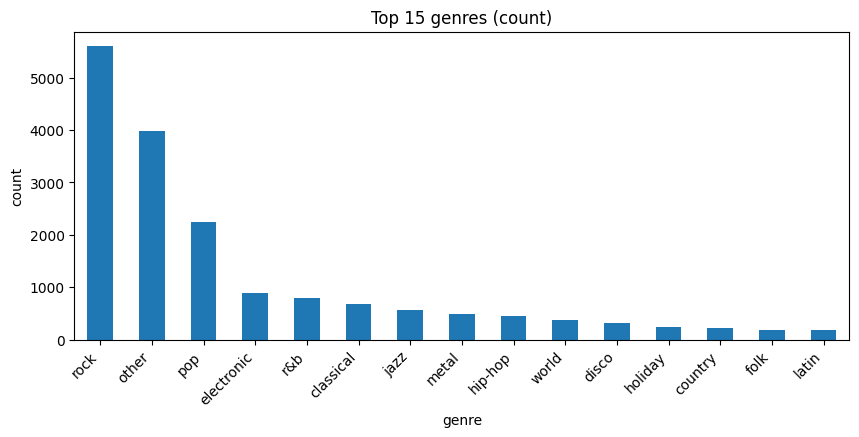

In [11]:
top = df["genre_final"].value_counts().head(15)
plt.figure(figsize=(10,4))
top.plot(kind="bar")
plt.title("Top 15 genres (count)")
plt.xlabel("genre")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.show()